# Run training on preprocessed data

Run: "a" 

Preprocessing is done by `run/run_ml_prep.py` and `src/core/ml_process.py`

## Training datasets

Signal: `nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`

Background: `nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`



In [26]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Internal modules 
sys.path.extend(["../../src/core", "../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [2]:
!ls ../../output/ml/cosmic/data/

bkg  sig  trained_xgboost.json


In [3]:
run = "a"
data_path = Path("../../output/ml/cosmic/")
sig_in_path = data_path / "data/sig" / run
bkg_in_path = data_path / "data/bkg" / run

sig_data = Load(in_path=sig_in_path).load_pkl()
bkg_data = Load(in_path=bkg_in_path).load_pkl()

[Load] ✅ Initialised with out_path=../../output/ml/cosmic/data/sig/a
[Load] ✅ Successfully loaded results from ../../output/ml/cosmic/data/sig/a/results.pkl
[Load] ✅ Initialised with out_path=../../output/ml/cosmic/data/bkg/a
[Load] ✅ Successfully loaded results from ../../output/ml/cosmic/data/bkg/a/results.pkl


## Verify data

In [4]:
display(sig_data["cut_flow"])
display(bkg_data["cut_flow"])

,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,1493499,100.000,100.000,No selection applied
1,has_trk_front,Preselect,1493210,99.981,99.981,Tracks intersect tracker entrance
2,is_reco_electron,Preselect,1491985,99.899,99.918,Electron track fits
3,one_reco_electron,Preselect,1487818,99.620,99.721,One reco electron / event
4,is_downstream,Preselect,1487812,99.619,100.000,Downstream tracks (p_z > 0 at tracker entrance)
5,is_truth_electron,Preselect,1487811,99.619,100.000,Track parents are electrons (truth PID)
6,good_trkqual,Tracker,1352474,90.557,90.904,Track fit quality > 0.2
7,within_t0,Tracker,980647,65.661,72.508,t0 at tracker entrance (640 < t_0 < 1650 ns)


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,2610933,100.000,100.000,No selection applied
1,has_trk_front,Preselect,2558235,97.982,97.982,Tracks intersect tracker entrance
2,is_reco_electron,Preselect,2478213,94.917,96.872,Electron track fits
3,one_reco_electron,Preselect,2051107,78.558,82.766,One reco electron / event
4,is_downstream,Preselect,1127293,43.176,54.960,Downstream tracks (p_z > 0 at tracker entrance)
5,is_truth_electron,Preselect,320796,12.287,28.457,Track parents are electrons (truth PID)
6,good_trkqual,Tracker,253945,9.726,79.161,Track fit quality > 0.2
7,within_t0,Tracker,203326,7.787,80.067,t0 at tracker entrance (640 < t_0 < 1650 ns)


[Load] ✅ Initialised with out_path=test_out
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[Plot] ⭐️ Initialised
*********************************** SIGNAL ***********************************


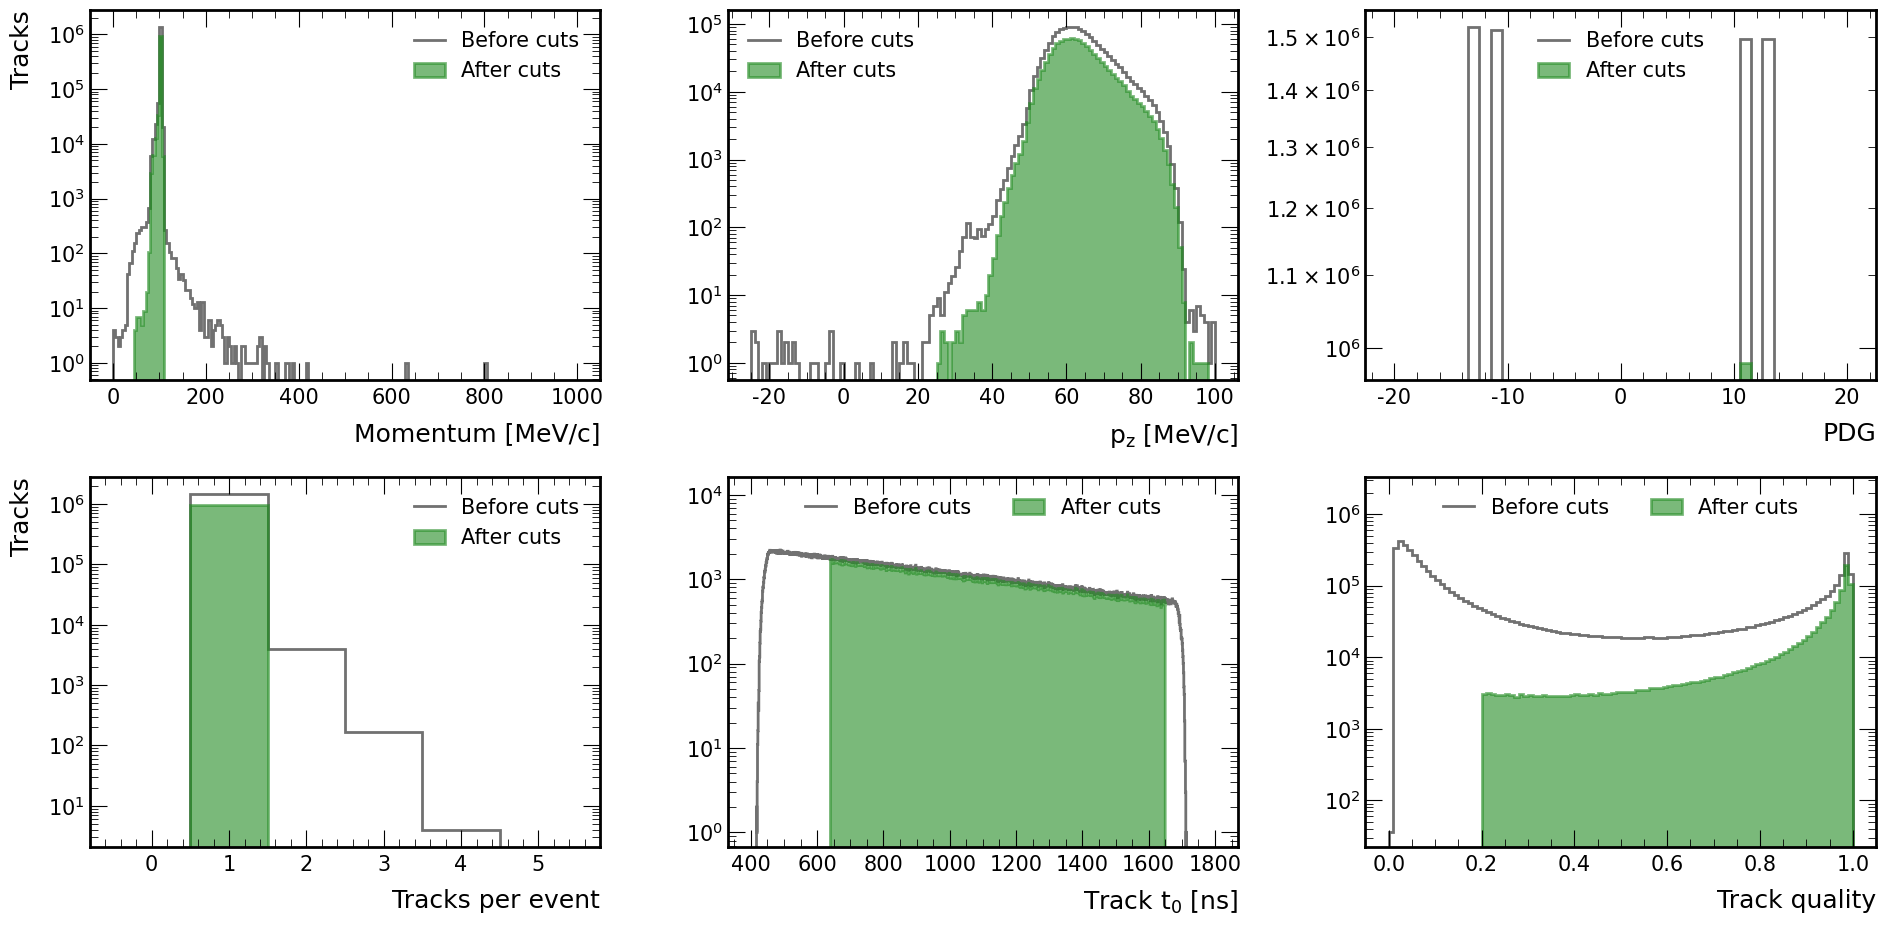

*********************************** BACKGROUND ***********************************


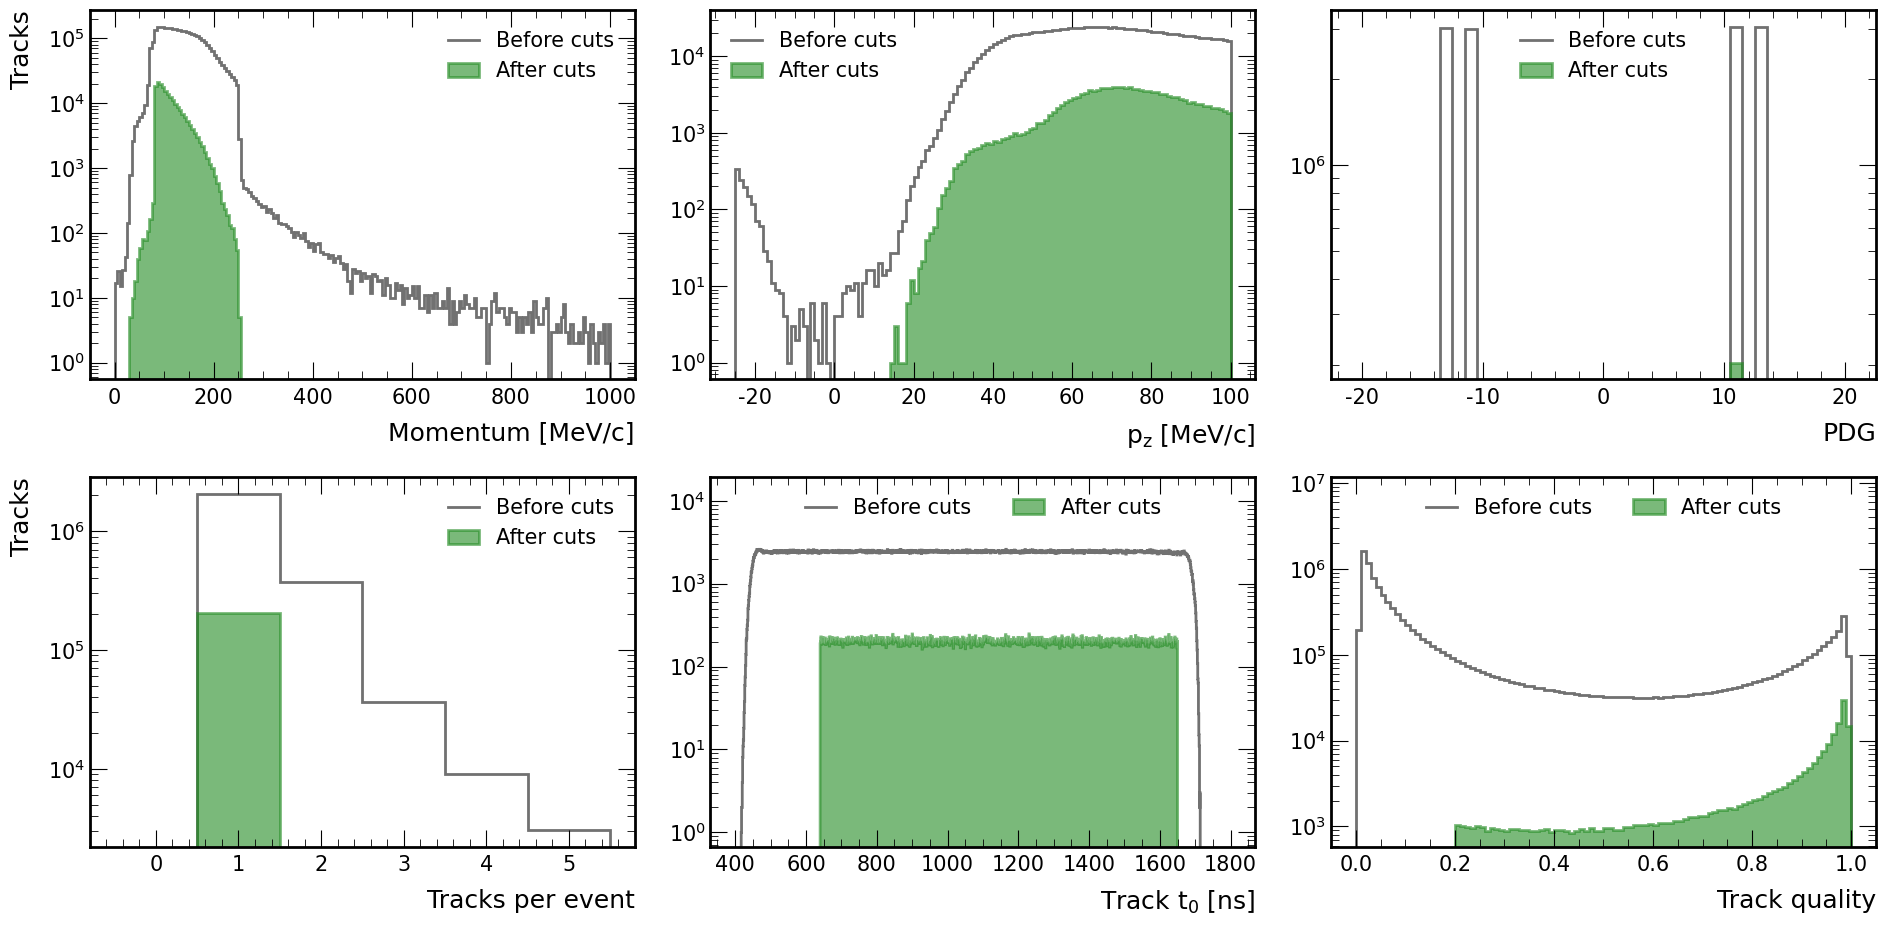

In [5]:
draw = Draw()

print("*"*35, "SIGNAL", "*"*35)
draw.plot_ml_summary(sig_data["hists"])

print("*"*35, "BACKGROUND", "*"*35)
draw.plot_ml_summary(bkg_data["hists"])

In [6]:
print(sig_data["events"].type)
print(bkg_data["events"].type)

980647 * {nactive: int32, t0err: float32, d0: float32, tanDip: float32, maxr: float32}
203326 * {nactive: int32, t0err: float32, d0: float32, tanDip: float32, maxr: float32}


## Training 

In [7]:
# Convert to DataFrame
feature_names = ["nactive", "t0err", "d0", "tanDip", "maxr"]

df_sig = ak.to_dataframe(sig_data["events"])
df_bkg = ak.to_dataframe(bkg_data["events"])

df_sig['label'] = 1
df_bkg['label'] = 0

In [8]:
# Combine and shuffle
df_train = pd.concat([df_sig, df_bkg], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_train)

,nactive,t0err,d0,tanDip,maxr,label
0,63,0.428916,57.088078,0.591628,628.251587,1
1,58,0.408326,222.161911,0.954052,608.521057,0
2,57,0.405947,110.867874,1.593542,589.830872,0
3,33,0.450032,40.529434,0.759309,482.940125,1
4,62,0.416622,38.685398,0.658637,597.931763,1
...,...,...,...,...,...,...
1183968,38,0.442987,71.200096,0.979107,553.594788,1
1183969,43,0.444610,18.446339,0.618925,544.823853,1
1183970,41,0.447440,13.091311,0.692259,562.031311,1
1183971,29,0.448754,23.516546,0.710111,524.939514,1


In [9]:
X = df_train.drop('label', axis=1)
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining: {len(X_train)} events")
print(f"Test: {len(X_test)} events")


Training: 947178 events
Test: 236795 events


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


In [11]:
print("\n🚀 Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Assign feature names for plotting / saving
model.get_booster().feature_names = feature_names

print("✅ Training complete!")


🚀 Training XGBoost model...
✅ Training complete!


## Store model

In [12]:
model_out_path = f"{data_path}/trained_xgboost.json"
model.save_model(model_out_path)
print(f"\n✅ Done! ROC curve saved to {model_out_path}")


✅ Done! ROC curve saved to ../../output/ml/cosmic/trained_xgboost.json


## Analyse model 


⭐️ Feature importance:
  nactive   : 0.0117
  t0err     : 0.0013
  d0        : 0.7272
  tanDip    : 0.0826
  maxr      : 0.1772


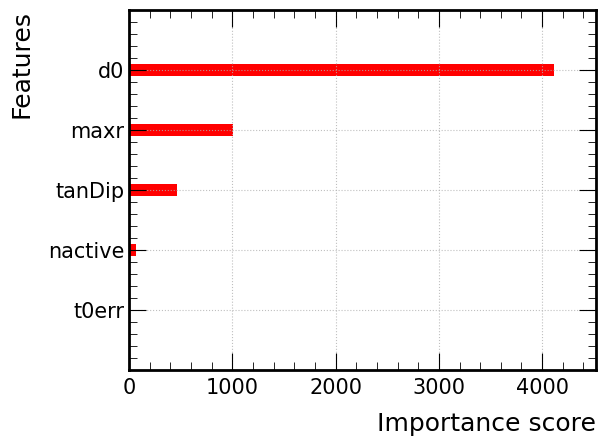

In [27]:
print("\n⭐️ Feature importance:") 
for feat, imp in zip(feature_names, model.feature_importances_):
    print(f"  {feat:10s}: {imp:.4f}") 

xgb.plot_importance(model, importance_type='gain', show_values=False)
plt.title("")
plt.tight_layout()
plt.show()

In [15]:
train_pred = model.predict_proba(X_train_scaled)[:, 1]
test_pred = model.predict_proba(X_test_scaled)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
test_auc = roc_auc_score(y_test, test_pred)

print(f"\nTraining AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training AUC: 0.9865
Test AUC: 0.9859


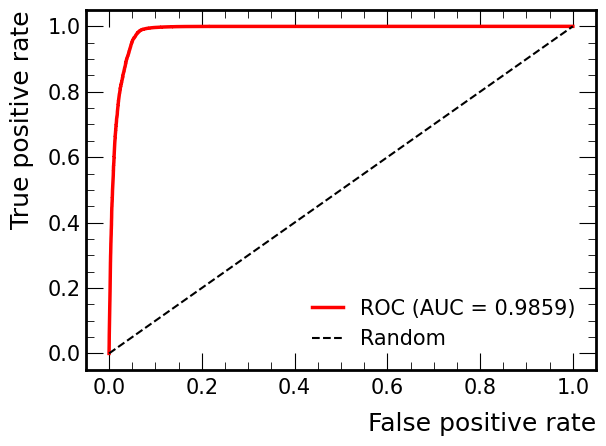


✅ Done! ROC curve saved to ../../output/images/ml/a/roc_curve.png


In [28]:
fpr, tpr, _ = roc_curve(y_test, test_pred)

plt.figure()
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()
out_path = f"../../output/images/ml/{run}/roc_curve.png"
plt.savefig(out_path)
plt.show()

print(f"\n✅ Done! ROC curve saved to {out_path}")

In [16]:
# print(model)                       # Full model structure summary
# print(model.get_params())           # Hyperparameters
# print(model.feature_importances_)   # Relative feature importance (you already printed these)

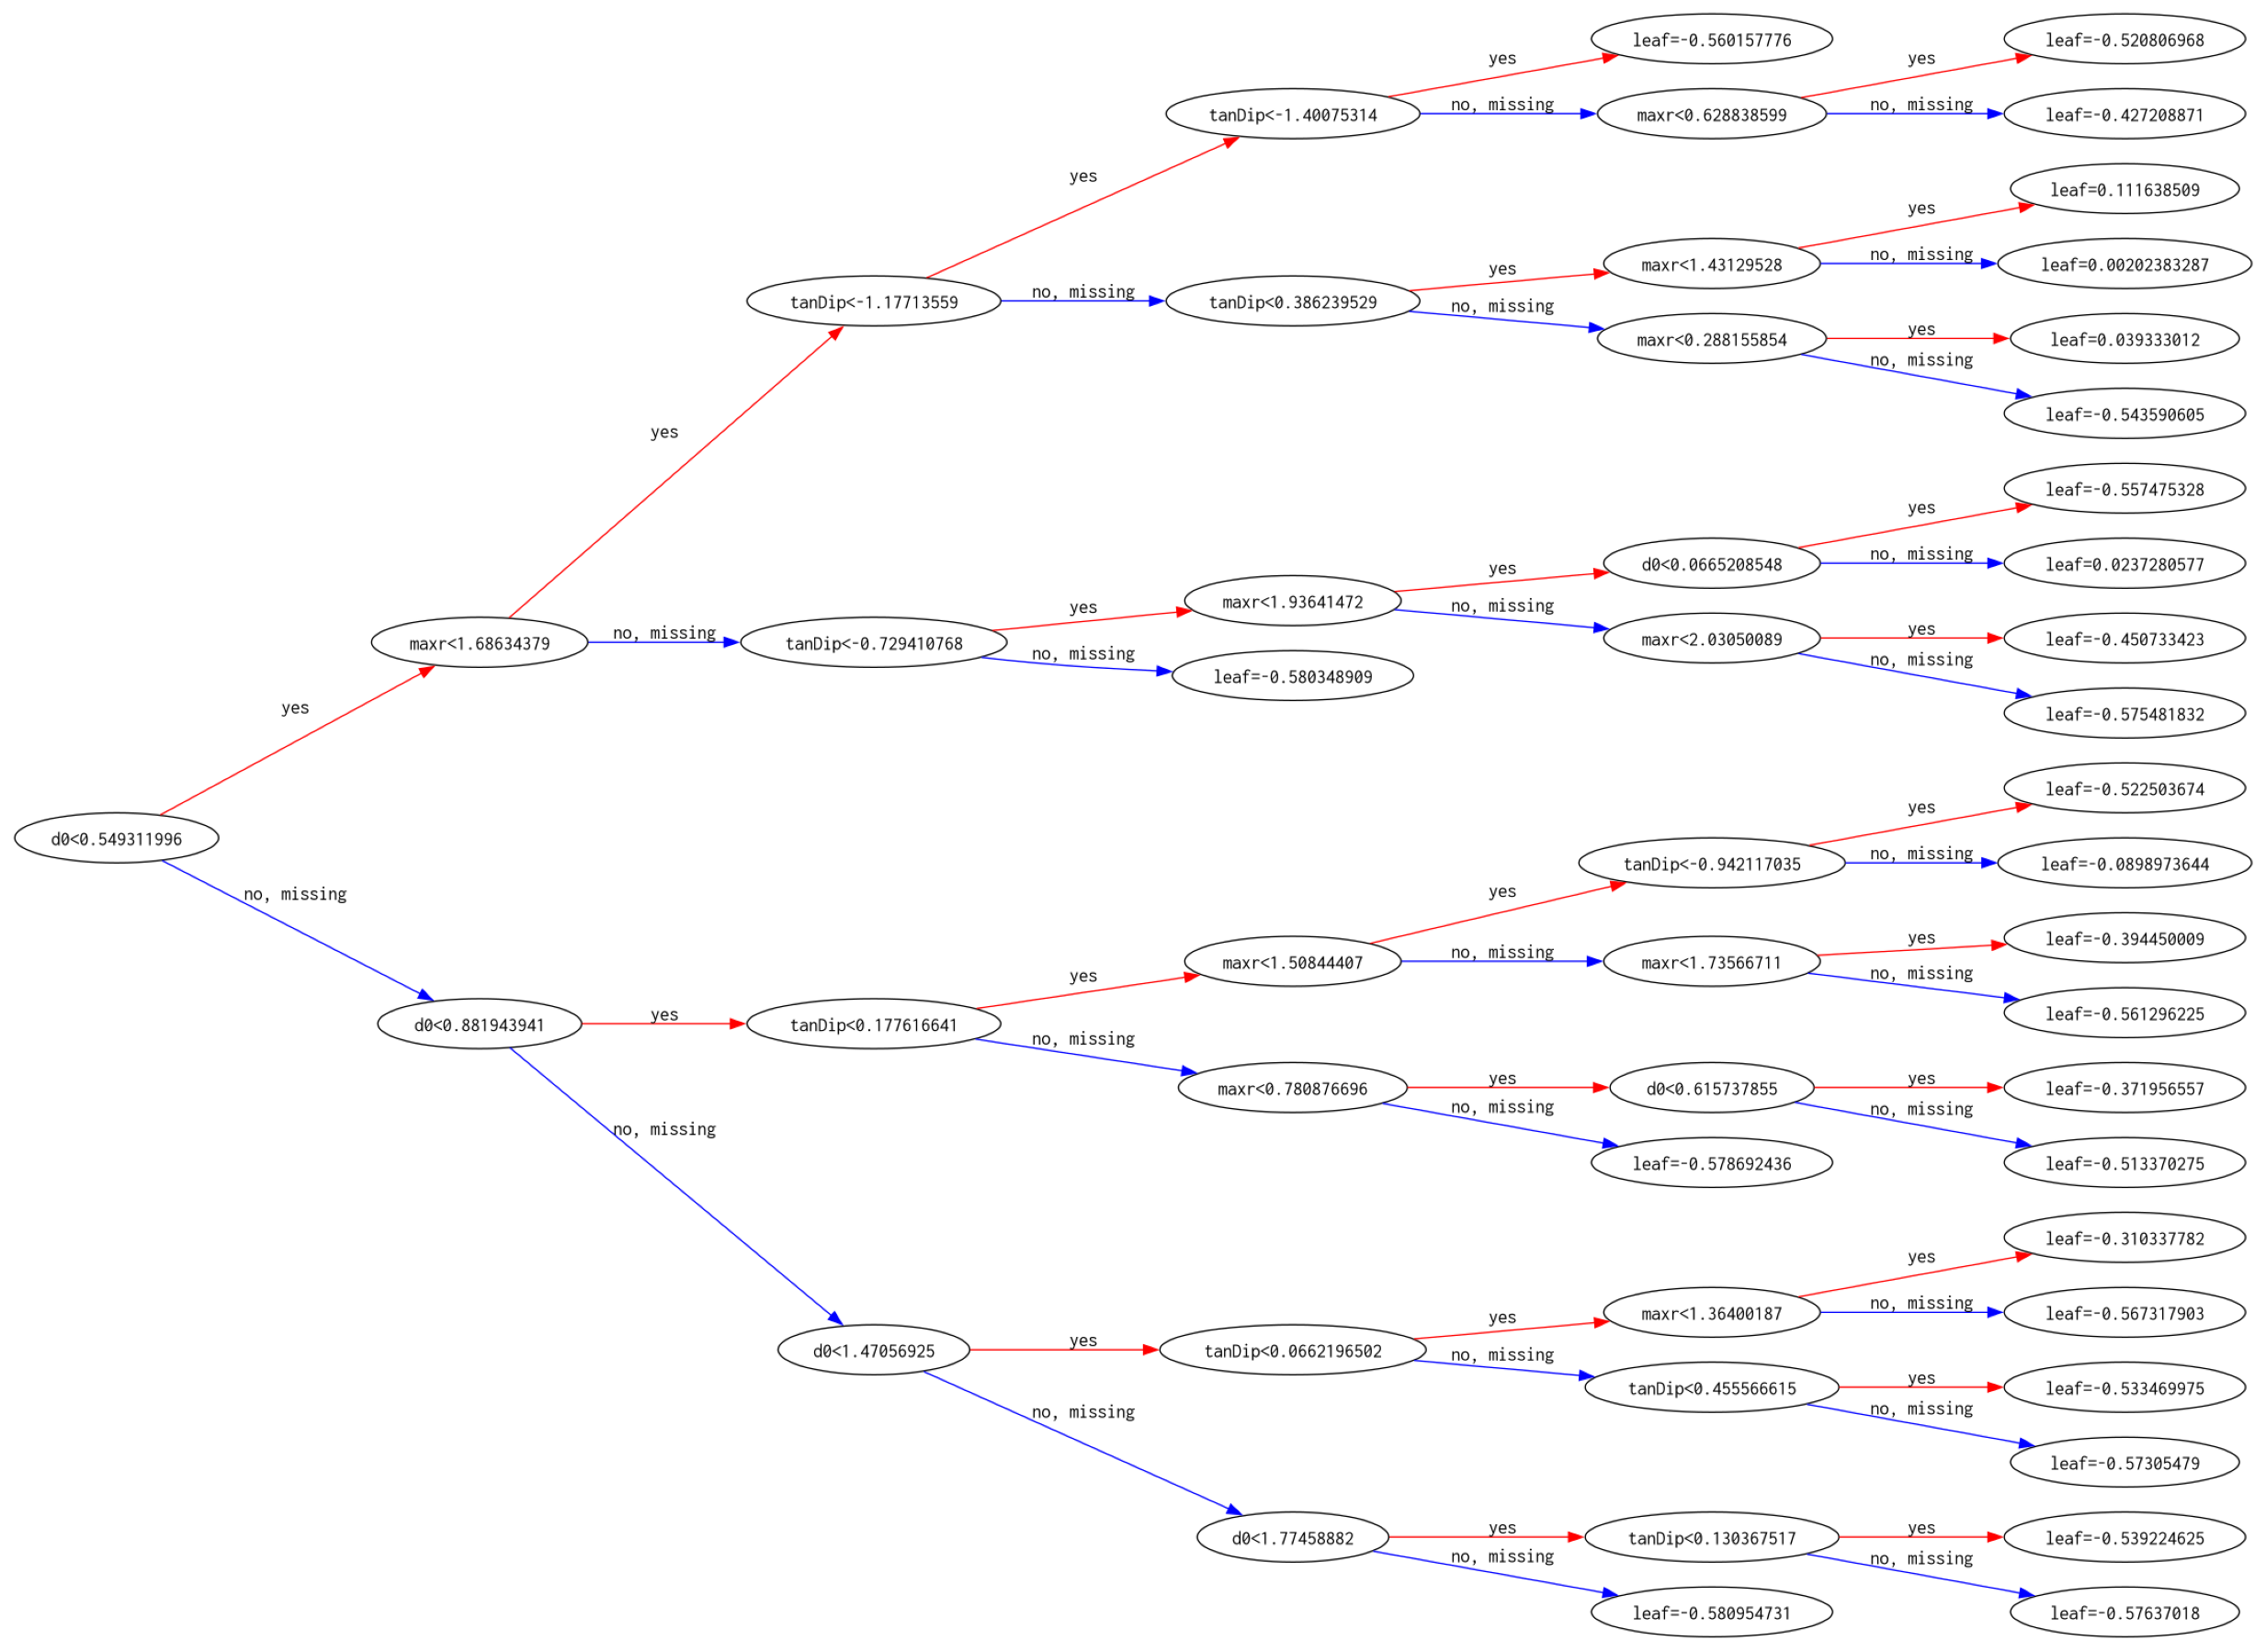


✅ Done! Tree saved to ../../output/images/ml/a/tree.png


In [29]:
fig, ax = plt.subplots(figsize=(25, 25))
xgb.plot_tree(model, num_trees=0, rankdir="LR", ax=ax)
plt.tight_layout()
out_path = f"../../output/images/ml/{run}/tree.png"
plt.savefig(out_path)
plt.show()

print(f"\n✅ Done! Tree saved to {out_path}")

Optimal threshold: 0.707
Maximum significance: 437.8


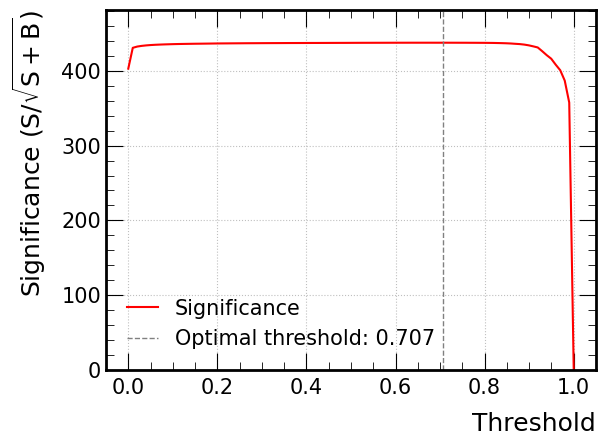


✅ Done! Signal signficance curve saved to ../../output/images/ml/a/sig_sif.png


In [30]:
thresholds = np.linspace(0, 1, 100)
Z_values = []
for thr in thresholds:
    y_pred_label = (test_pred > thr).astype(int)
    S = ((y_test == 1) & (y_pred_label == 1)).sum()
    B = ((y_test == 0) & (y_pred_label == 1)).sum()
    if S+B > 0:
        Z_values.append(S / np.sqrt(S + B))
    else:
        Z_values.append(0)

optimal_idx = np.argmax(Z_values)
optimal_threshold = thresholds[optimal_idx]
max_significance = Z_values[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Maximum significance: {max_significance:.1f}")

plt.plot(thresholds, Z_values, label="Significance")
plt.ylim(0, max(Z_values) * 1.1)  # 10% headroom
plt.axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1, label=f'Optimal threshold: {optimal_threshold:.3f}')
plt.legend(loc="lower left")
plt.xlabel("Threshold")
plt.ylabel(r"Significance ($S/\sqrt{S+B}$)")
plt.grid()
plt.tight_layout()
out_path = f"../../output/images/ml/{run}/sig_sif.png"
plt.savefig(out_path)
plt.show()

print(f"\n✅ Done! Signal signficance curve saved to {out_path}")

In [31]:
# print(plt.style.library)

In [19]:
# # Choose your threshold based on desired signal efficiency
# threshold = 0.5  # Standard choice

# # Make binary decisions
# predictions = test_scores > threshold
# # predictions = [True, False, True, False, True, ...]

# # Or more explicitly:
# ce_selection = test_scores > threshold
# selected_events = X_test[ce_selection]

# print(f"Selected {ce_selection.sum()} events as CEs")

In [20]:
# import matplotlib.pyplot as plt

# # Separate scores by true label
# signal_scores = test_scores[y_test == 1]  # True signal
# cosmic_scores = test_scores[y_test == 0]  # True background

# plt.figure(figsize=(10, 6))
# plt.hist(cosmic_scores, bins=50, alpha=0.6, label='Cosmics', 
#          density=True, color='orange')
# plt.hist(ce_scores, bins=50, alpha=0.6, label='CEs', 
#          density=True, color='blue')

# plt.axvline(0.5, color='grey', linestyle='--', linewidth=1, 
#             label=f'Threshold = {optimal_threshold}')

# plt.xlabel('Model score')
# plt.ylabel('Density')
# plt.title('Score distribution')
# plt.legend()

# plt.show()

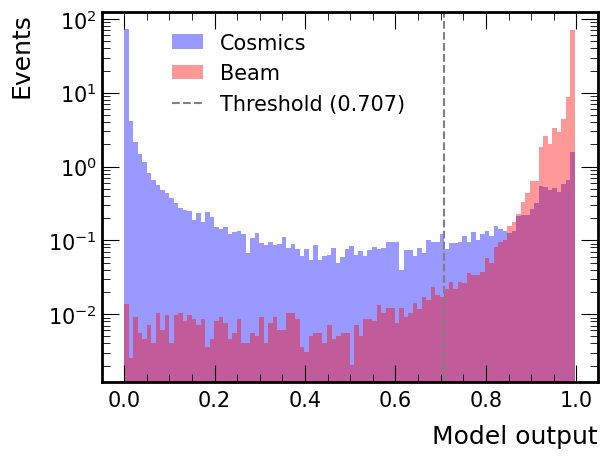

In [39]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # True signal (CEs)
cosmic_scores = test_scores[y_test == 0]  # True background (Cosmics)

# Define threshold
threshold = 0.5

# Compute FPR and FNR
false_positives = (cosmic_scores > threshold).sum()   # Background misclassified as signal
true_negatives  = (cosmic_scores <= threshold).sum()

false_negatives = (signal_scores <= threshold).sum()  # Signal misclassified as background
true_positives  = (signal_scores > threshold).sum()

fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)

# Plot score distributions
plt.figure() 

plt.hist(cosmic_scores, bins=100, alpha=0.4, label='Cosmics',
         density=True, color='blue')
plt.hist(signal_scores, bins=100, alpha=0.4, label='Beam',
         density=True, color='red')

plt.axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


plt.xlabel('Model output')
plt.ylabel('Events')
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
plt.yscale('log')

plt.show()


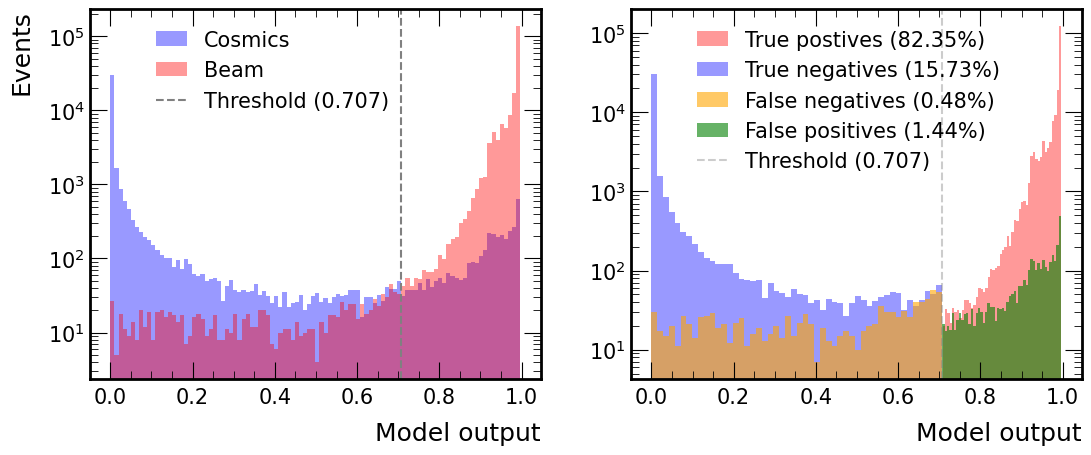

In [73]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # True signal 
cosmic_scores = test_scores[y_test == 0]  # True background 

# Discrimination threshold
threshold = optimal_threshold

# Get false positives and false negatives
false_positives = cosmic_scores[cosmic_scores > threshold]
false_negatives = signal_scores[signal_scores <= threshold]

# Also get true positives and true negatives for comparison
true_positives = signal_scores[signal_scores > threshold]
true_negatives = cosmic_scores[cosmic_scores <= threshold]

# # Boolean masks
# tp_mask = (y_test == 1) & (y_pred_label == 1)
# tn_mask = (y_test == 0) & (y_pred_label == 0)
# fp_mask = (y_test == 0) & (y_pred_label == 1)
# fn_mask = (y_test == 1) & (y_pred_label == 0)


tot = len(test_scores)

# Plot score distributions
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

ax[0].hist(cosmic_scores, bins=100, alpha=0.4, label='Cosmics',
         density=False, color='blue')
ax[0].hist(signal_scores, bins=100, alpha=0.4, label='Beam',
         density=False, color='red')
ax[0].axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


ax[0].set_xlabel('Model output')
ax[0].set_ylabel('Events')
ax[0].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[0].set_yscale('log')


ax[1].hist(true_positives, bins=50, alpha=0.4, label=f'True postives ({len(true_positives)*100/tot:.2f}%)', color='red')
ax[1].hist(true_negatives, bins=50, alpha=0.4, label=f'True negatives ({len(true_negatives)*100/tot:.2f}%)', color='blue')
ax[1].hist(false_negatives, bins=50, alpha=0.6, label=f'False negatives ({len(false_negatives)*100/tot:.2f}%)', color='orange')
ax[1].hist(false_positives, bins=50, alpha=0.6, label=f'False positives ({len(false_positives)*100/tot:.2f}%)', color='green')
ax[1].axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, alpha=0.4, label=f"Threshold ({optimal_threshold:.3f})")


ax[1].set_xlabel('Model output')
ax[1].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[1].set_yscale('log')


plt.show()


In [82]:
X_test_scaled

array([[-0.55645783, -0.27832736, -0.61962159, -0.85490828, -0.02135168],
       [-0.76640152, -0.19750665,  0.12687301, -0.41930555, -1.35682202],
       [-1.46621382, -0.12697703,  0.59624474,  0.27487708, -0.81531951],
       ...,
       [ 0.28331693, -0.28067537, -0.0019874 ,  0.06577673,  0.26380258],
       [ 0.84316677, -0.44689293, -0.49011902, -0.66889314,  0.4415214 ],
       [-0.4864766 , -0.26362161, -0.44578287, -0.33408852,  0.22801053]])

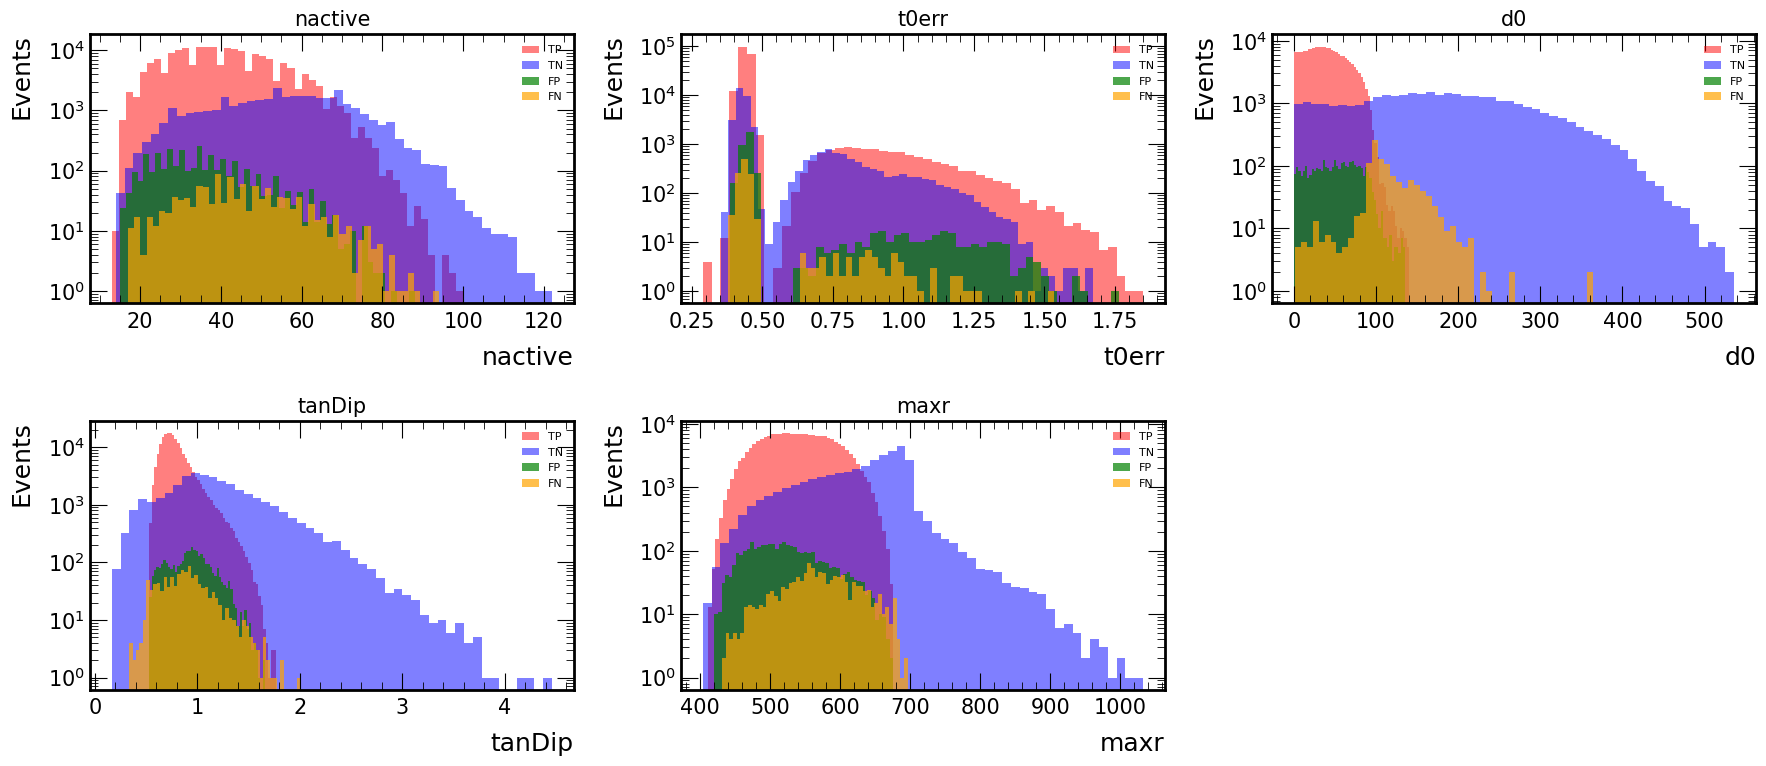

In [93]:
# Create a grid of subplots
n_features = len(feature_names)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

y_pred_label = (test_scores > threshold).astype(int)
# Boolean masks
tp_mask = (y_test == 1) & (y_pred_label == 1)
tn_mask = (y_test == 0) & (y_pred_label == 0)
fp_mask = (y_test == 0) & (y_pred_label == 1)
fn_mask = (y_test == 1) & (y_pred_label == 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    ax.hist(X_test[feature][tp_mask], bins=50, color='red', alpha=0.5, label='TP')
    ax.hist(X_test[feature][tn_mask], bins=50, color='blue', alpha=0.5, label='TN')
    ax.hist(X_test[feature][fp_mask], bins=50, color='green', alpha=0.7, label='FP')
    ax.hist(X_test[feature][fn_mask], bins=50, color='orange', alpha=0.7, label='FN')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Events')
    ax.set_yscale('log')
    ax.legend(fontsize=8)
    ax.set_title(feature)

# Hide unused subplots
for idx in range(len(feature_names), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [87]:
# true_positives.keys()

In [94]:
# Signal efficiency (True Positive Rate / Recall)
signal_efficiency = len(true_positives) / len(signal_scores)

# Background rejection rate (True Negative Rate / Specificity)
background_rejection = len(true_negatives) / len(cosmic_scores)

# Background efficiency (what you're rejecting FROM)
background_efficiency = len(false_positives) / len(cosmic_scores)

print(f"Signal Efficiency: {signal_efficiency*100:.2f}%")
print(f"Background Rejection: {background_rejection*100:.2f}%")
print(f"Background Contamination: {background_efficiency*100:.2f}%")

# Check class balance
print(f"\nClass balance:")
print(f"Signal events: {len(signal_scores)} ({len(signal_scores)*100/tot:.2f}%)")
print(f"Background events: {len(cosmic_scores)} ({len(cosmic_scores)*100/tot:.2f}%)")

Signal Efficiency: 99.42%
Background Rejection: 91.62%
Background Contamination: 8.38%

Class balance:
Signal events: 196130 (82.83%)
Background events: 40665 (17.17%)


In [ ]:
## Kinematic cuts

In [132]:
# Example traditional cuts (adjust these to your physics case)
def apply_kin_cuts(X):
    """Apply kinematic parameter cuts for signal selection"""
    cuts = (
        (X['d0'] < 100) &           
        (X['maxr'] < 680) &         
        (X['tanDip'] > 0.5) &  
        (X['tanDip'] < 1.0) &        
        (X['t0err'] < 0.9)   
    )
    return cuts

# Apply cuts to test set

cut_based_pred = apply_kin_cuts(X_test).astype(int)

print(X_test)
print(len(cut_based_pred[cut_based_pred==1])/len(cut_based_pred))
# print(len(X_test), len(cut_based_pred[2]))
# cut_based_pred = apply_kin_cuts(X_test).astype(int)

        nactive     t0err          d0    tanDip        maxr
106580       35  0.440553   19.414326  0.619350  552.197754
249343       32  0.452949   70.437500  0.738878  469.730743
97689        22  0.463767  102.519226  0.929359  503.169220
676716       42  0.891885   12.635576  0.803549  536.112122
567957       57  0.428158   29.320721  0.683455  579.927917
...         ...       ...         ...       ...         ...
596286       44  0.422115    9.525817  0.693120  542.348511
973735       30  0.463604   13.379064  0.810730  508.427307
983897       47  0.440193   61.629845  0.871983  569.806396
928082       55  0.414699   28.265873  0.670392  580.780762
252837       36  0.442809   31.296265  0.762261  567.596191

[236795 rows x 5 columns]
0.7409446990012458


In [116]:
from sklearn.metrics import confusion_matrix, classification_report

# ML predictions
y_pred_ml = (test_scores > optimal_threshold).astype(int)

# Calculate confusion matrices
cm_ml = confusion_matrix(y_test, y_pred_ml)
cm_cuts = confusion_matrix(y_test, cut_based_pred)

# Extract TP, TN, FP, FN for both methods
def get_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    
    signal_efficiency = tp / (tp + fn) if (tp + fn) > 0 else 0
    background_rejection = tn / (tn + fp) if (tn + fp) > 0 else 0
    purity = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate significance
    S = tp
    B = fp
    significance = S / np.sqrt(S + B) if (S + B) > 0 else 0
    
    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Signal efficiency': signal_efficiency,
        'Background rejection': background_rejection,
        'Purity': purity,
        'Significance': significance
    }

metrics_ml = get_metrics(cm_ml)
metrics_cuts = get_metrics(cm_cuts)

# # Print comparison
# print("=" * 60)
# print("Performance comparison: ML vs kinematic cuts")
# print("=" * 60)
# print(f"{'Metric':<25} {'ML':<15} {'Cuts':<15} {'Improvement':<15}")
# print("-" * 60)

# for key in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']:
#     ml_val = metrics_ml[key]
#     cut_val = metrics_cuts[key]
#     improvement = ((ml_val - cut_val) / cut_val * 100) if cut_val > 0 else 0
    
#     print(f"{key:<25} {ml_val:.4f}        {cut_val:.4f}        {improvement:+.1f}%")

# print("-" * 60)
# print(f"{'True positives':<25} {metrics_ml['TP']:<15} {metrics_cuts['TP']:<15}")
# print(f"{'False positives':<25} {metrics_ml['FP']:<15} {metrics_cuts['FP']:<15}")
# print(f"{'False negatives':<25} {metrics_ml['FN']:<15} {metrics_cuts['FN']:<15}")
# print(f"{'True negatives':<25} {metrics_ml['TN']:<15} {metrics_cuts['TN']:<15}")


# Metrics DataFrame (with percentages/rates)
metrics_df = pd.DataFrame({
    'Metric': ['Signal efficiency', 'Background rejection', 'Purity', 'Significance'],
    'ML': [metrics_ml[k] for k in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']],
    'Cuts': [metrics_cuts[k] for k in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']]
})
metrics_df['Improvement [%]'] = ((metrics_df['ML'] - metrics_df['Cuts']) / metrics_df['Cuts'] * 100)

# Counts DataFrame
# counts_df = pd.DataFrame({
#     'Category': ['True positives', 'False positives', 'False negatives', 'True negatives'],
#     'ML': [metrics_ml['TP'], metrics_ml['FP'], metrics_ml['FN'], metrics_ml['TN']],
#     'Cuts': [metrics_cuts['TP'], metrics_cuts['FP'], metrics_cuts['FN'], metrics_cuts['TN']]
# })

counts_df = pd.DataFrame({
    'Category': ['True positives', 'True negatives', 'False positives', 'False negatives'],
    'ML': [metrics_ml['TP'], metrics_ml['TN'], metrics_ml['FP'], metrics_ml['FN']],
    'Cuts': [metrics_cuts['TP'], metrics_cuts['TN'], metrics_cuts['FP'], metrics_cuts['FN']]
})

counts_df['Difference'] = counts_df['ML'] - counts_df['Cuts']

print("\n=== Performance metrics ===")
display(metrics_df)
print("\n=== Event counts ===")
display(counts_df)




=== Performance metrics ===


,Metric,ML,Cuts,Improvement [%]
0,Signal efficiency,0.994208,0.873441,13.826558
1,Background rejection,0.916242,0.898094,2.020755
2,Purity,0.982833,0.976381,0.660772
3,Significance,437.774453,408.976622,7.041437



=== Event counts ===


,Category,ML,Cuts,Difference
0,True positives,194994,171308,23686
1,True negatives,37259,36521,738
2,False positives,3406,4144,-738
3,False negatives,1136,24822,-23686


In [140]:
# Cosmic Ray Rejection Performance Table
cosmic_rejection_df = pd.DataFrame({
    'Metric': [
        'Cosmic rays rejected (TN)',
        'Cosmic rays accepted (FP)', 
        'Background rejection rate',
        'Cosmic contamination rate',
        'Sample purity (beam)',
        'Beam events retained (TP)',
        'Beam signal efficiency',
        'Overall significance (S/√(S+B))'
    ],
    'ML': [
        metrics_ml['TN'],
        metrics_ml['FP'],
        f"{metrics_ml['Background rejection']*100:.2f}%",
        f"{(metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']))*100:.2f}%",
        f"{metrics_ml['Purity']*100:.2f}%",
        metrics_ml['TP'],
        f"{metrics_ml['Signal efficiency']*100:.2f}%",
        f"{metrics_ml['Significance']:.1f}"
    ],
    'Cuts': [
        metrics_cuts['TN'],
        metrics_cuts['FP'],
        f"{metrics_cuts['Background rejection']*100:.2f}%",
        f"{(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100:.2f}%",
        f"{metrics_cuts['Purity']*100:.2f}%",
        metrics_cuts['TP'],
        f"{metrics_cuts['Signal efficiency']*100:.2f}%",
        f"{metrics_cuts['Significance']:.1f}"
    ],
    'Improvement': [
        f"+{metrics_ml['TN'] - metrics_cuts['TN']}",
        f"{metrics_ml['FP'] - metrics_cuts['FP']}",
        f"+{((metrics_ml['Background rejection'] - metrics_cuts['Background rejection'])/metrics_cuts['Background rejection']*100):.1f}%",
        f"{((metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']) - metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))/(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100):.1f}%",
        f"+{(metrics_ml['Purity'] - metrics_cuts['Purity'])*100:.2f} pp",
        f"+{metrics_ml['TP'] - metrics_cuts['TP']}",
        f"+{((metrics_ml['Signal efficiency'] - metrics_cuts['Signal efficiency'])/metrics_cuts['Signal efficiency']*100):.1f}%",
        f"+{((metrics_ml['Significance'] - metrics_cuts['Significance'])/metrics_cuts['Significance']*100):.1f}%"
    ]
})

print("\n" + "="*80)
print("COSMIC RAY REJECTION PERFORMANCE: ML vs Kinematic Cuts")
print("="*80)
display(cosmic_rejection_df)

# Add summary statistics
total_cosmics = metrics_ml['TN'] + metrics_ml['FP']
total_beam = metrics_ml['TP'] + metrics_ml['FN']

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"• ML rejects {metrics_ml['TN'] - metrics_cuts['TN']} additional cosmic ray backgrounds")
print(f"• ML reduces cosmic contamination by {abs((metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']) - metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))/(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100):.1f}%")
print(f"• ML retains {metrics_ml['TP'] - metrics_cuts['TP']} additional beam events")
print(f"• Net result: {((metrics_ml['Significance'] - metrics_cuts['Significance'])/metrics_cuts['Significance']*100):.1f}% improvement in significance")
print(f"\nDataset composition: {total_beam:,} beam events, {total_cosmics:,} cosmic events")


COSMIC RAY REJECTION PERFORMANCE: ML vs Kinematic Cuts


,Metric,ML,Cuts,Improvement
0,Cosmic rays rejected (TN),37259,36521,+738
1,Cosmic rays accepted (FP),3406,4144,-738
2,Background rejection rate,91.62%,89.81%,+2.0%
3,Cosmic contamination rate,8.38%,10.19%,-17.8%
4,Sample purity (beam),98.28%,97.64%,+0.65 pp
5,Beam events retained (TP),194994,171308,+23686
6,Beam signal efficiency,99.42%,87.34%,+13.8%
7,Overall significance (S/√(S+B)),437.8,409.0,+7.0%



KEY FINDINGS
• ML rejects 738 additional cosmic ray backgrounds
• ML reduces cosmic contamination by 17.8%
• ML retains 23686 additional beam events
• Net result: 7.0% improvement in significance

Dataset composition: 196,130 beam events, 40,665 cosmic events


In [138]:
# # Selection rate on PURE signal dataset
# signal_selection_rate = metrics_cuts['TP'] / (metrics_cuts['TP'] + metrics_cuts['FN'])
# print(f"Signal selection rate (cuts): {signal_selection_rate:.4f} ({signal_selection_rate*100:.2f}%)")

# # This is actually the same as signal efficiency!
# # It's asking: "Of all signal events, what fraction passes cuts?"

# # For comparison - ML signal selection rate
# signal_selection_rate_ml = metrics_ml['TP'] / (metrics_ml['TP'] + metrics_ml['FN'])
# print(f"Signal selection rate (ML): {signal_selection_rate_ml:.4f} ({signal_selection_rate_ml*100:.2f}%)")

# # Background selection rate (what fraction of background passes - you want this LOW)
# background_selection_rate_cuts = metrics_cuts['FP'] / (metrics_cuts['FP'] + metrics_cuts['TN'])
# background_selection_rate_ml = metrics_ml['FP'] / (metrics_ml['FP'] + metrics_ml['TN'])

# print(f"\nBackground selection rate (cuts): {background_selection_rate_cuts:.4f} ({background_selection_rate_cuts*100:.2f}%)")
# print(f"Background selection rate (ML): {background_selection_rate_ml:.4f} ({background_selection_rate_ml*100:.2f}%)")

# Apply cuts to the pure signal dataset
cut_based_sig = apply_kin_cuts(df_sig.drop('label', axis=1))

# Calculate selection rate on pure signal sample
signal_selection_rate = cut_based_sig.sum() / len(df_sig)
print(f"Selection rate on pure signal dataset: {signal_selection_rate:.4f} ({signal_selection_rate*100:.2f}%)")
print(f"Events passing cuts: {cut_based_sig.sum()} / {len(df_sig)}")

# Compare to what you got on test set
print(f"\nFor comparison:")
print(f"Signal efficiency on test set: {metrics_cuts['Signal efficiency']:.4f} ({metrics_cuts['Signal efficiency']*100:.2f}%)")

# Apply cuts to pure background dataset
cut_based_bkg = apply_kin_cuts(df_bkg.drop('label', axis=1))

background_selection_rate = cut_based_bkg.sum() / len(df_bkg)
print(f"Selection rate on pure background dataset: {background_selection_rate:.4f} ({background_selection_rate*100:.2f}%)")
print(f"\nFor comparison:")
print(f"Background contamination on test set: {1 - metrics_cuts['Background rejection']:.4f} ({(1 - metrics_cuts['Background rejection'])*100:.2f}%)")

Selection rate on pure signal dataset: 0.8735 (87.35%)
Events passing cuts: 856597 / 980647

For comparison:
Signal efficiency on test set: 0.8734 (87.34%)
Selection rate on pure background dataset: 0.1034 (10.34%)

For comparison:
Background contamination on test set: 0.1019 (10.19%)


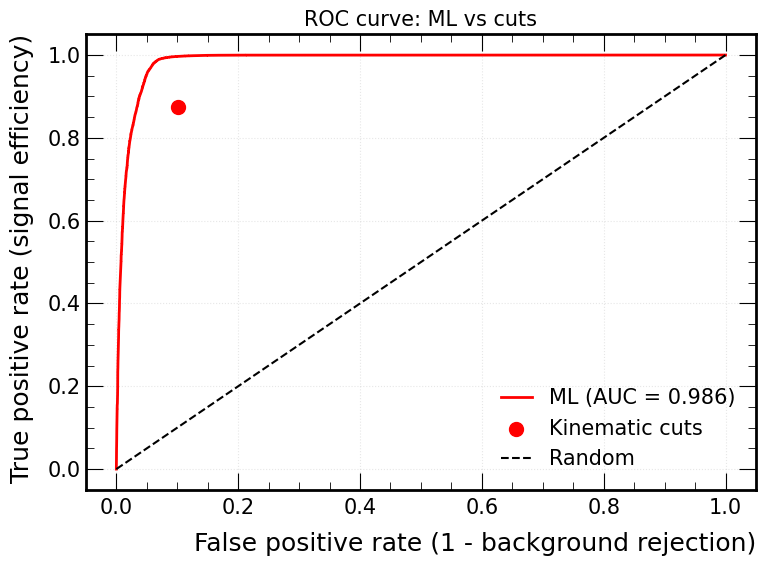

In [105]:
from sklearn.metrics import roc_curve, auc

# ML ROC curve
fpr_ml, tpr_ml, _ = roc_curve(y_test, test_scores)
roc_auc_ml = auc(fpr_ml, tpr_ml)

# For cut-based, create a simple ROC point
tpr_cuts = metrics_cuts['Signal efficiency']
fpr_cuts = 1 - metrics_cuts['Background rejection']

plt.figure(figsize=(8, 6))
plt.plot(fpr_ml, tpr_ml, label=f'ML (AUC = {roc_auc_ml:.3f})', linewidth=2)
plt.scatter(fpr_cuts, tpr_cuts, color='red', s=100, zorder=5, 
           label=f'Kinematic cuts', marker='o')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False positive rate (1 - background rejection)')
plt.ylabel('True positive rate (signal efficiency)')
plt.title('ROC curve: ML vs cuts')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

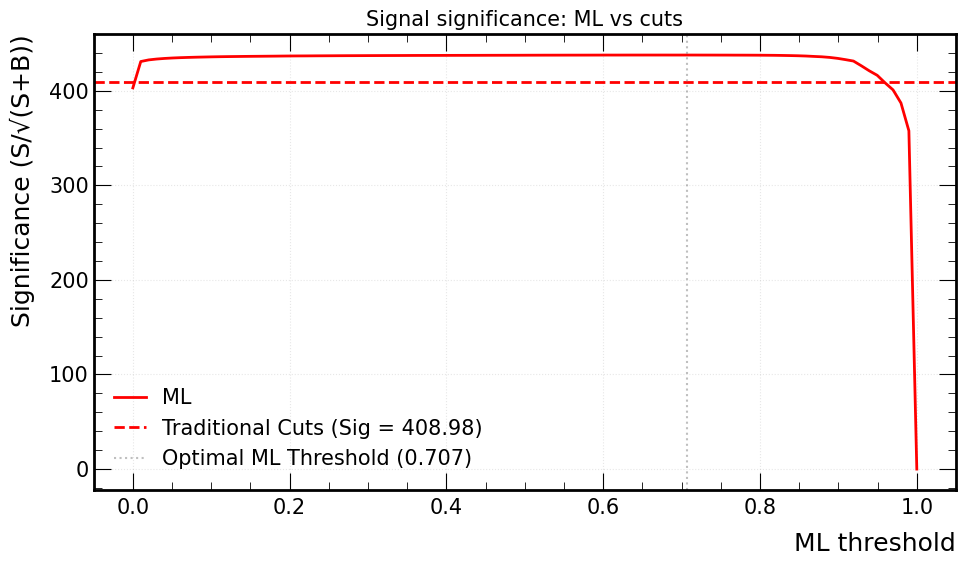


Maximum ML Significance: 437.77
Cut-based Significance: 408.98
Improvement: 7.0%


In [108]:
# Scan thresholds for both methods
thresholds_ml = np.linspace(0, 1, 100)
significance_ml = []

for thr in thresholds_ml:
    y_pred = (test_scores > thr).astype(int)
    S = ((y_test == 1) & (y_pred == 1)).sum()
    B = ((y_test == 0) & (y_pred == 1)).sum()
    sig = S / np.sqrt(S + B) if (S + B) > 0 else 0
    significance_ml.append(sig)

# Get cut-based significance (single point)
S_cuts = metrics_cuts['TP']
B_cuts = metrics_cuts['FP']
sig_cuts = metrics_cuts['Significance']

plt.figure(figsize=(10, 6))
plt.plot(thresholds_ml, significance_ml, label='ML', linewidth=2)
plt.axhline(sig_cuts, color='red', linestyle='--', linewidth=2, 
           label=f'Traditional Cuts (Sig = {sig_cuts:.2f})')
plt.axvline(optimal_threshold, color='grey', linestyle=':', alpha=0.5,
           label=f'Optimal ML Threshold ({optimal_threshold:.3f})')
plt.xlabel('ML threshold')
plt.ylabel('Significance (S/√(S+B))')
plt.title('Signal significance: ML vs cuts')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMaximum ML Significance: {max(significance_ml):.2f}")
print(f"Cut-based Significance: {sig_cuts:.2f}")
print(f"Improvement: {(max(significance_ml) - sig_cuts)/sig_cuts*100:.1f}%")

In [109]:
# Show which events pass ML but fail cuts, and vice versa
ml_only = (y_pred_ml == 1) & (cut_based_pred == 0)
cuts_only = (y_pred_ml == 0) & (cut_based_pred == 1)
both = (y_pred_ml == 1) & (cut_based_pred == 1)

print(f"\nEvents passing ML only: {ml_only.sum()}")
print(f"Events passing Cuts only: {cuts_only.sum()}")
print(f"Events passing both: {both.sum()}")


Events passing ML only: 25300
Events passing Cuts only: 2352
Events passing both: 173100


In [78]:
# feature = 'd0'

# plt.figure(figsize=(8,6))
# plt.hist(X_test[feature][tp_mask], bins=50, color='royalblue', alpha=0.5, label='True Positives')
# plt.hist(X_test[feature][fp_mask], bins=50, color='green', alpha=0.5, label='False Positives')
# plt.hist(X_test[feature][fn_mask], bins=50, color='khaki', alpha=0.7, label='False Negatives')
# plt.hist(X_test[feature][tn_mask], bins=50, color='red', alpha=0.5, label='True Negatives')
# plt.xlabel(feature)
# plt.ylabel('# of events')
# plt.yscale('log')
# plt.legend()
# plt.title(f'{feature} distribution by classification result')
# plt.show()


In [79]:
# # import xgboost as xgb
# # import matplotlib.pyplot as plt

# # xgb.plot_tree(model, num_trees=0, rankdir="LR")  # "LR" = left-to-right
# # plt.show()

# from xgboost import to_graphviz

# # Generate a Graphviz object
# dot = to_graphviz(model, num_trees=0, rankdir="LR")

# # Save as a crisp vector PDF
# dot.render("xgb_tree", format="pdf")

# # or as a high-quality PNG (set dpi)
# dot.render("xgb_tree", format="png")



In [80]:
# xgb.plot_importance(model, importance_type='gain')
# plt.tight_layout()
# plt.show()